<a href="https://colab.research.google.com/github/pedrofuentes79/RNNs/blob/master/Sentiment-Analysis/sentAnalysis_Main_(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Idea for the project

The project is aimed to solve the following problem: given a review (or any piece of text), classify it as positive or negative. Since it was trained using amazon product reviews, it was tested on those same types of text: product reviews.  

This problem is, in this case, solved using a <b>RNN</b> (Recursive Neural Network), which is a type of neural network that is able to take into account the previous information that it was given. In this particular problem, sentiment analysis, it is important to take into account the previous words in order to understand the context of the sentence. For example, the sentence "I love this product" is positive, but "I don't love this product" is negative.

The model is then compared to other models, shown in other notebooks (see [Conclusions](#conclusions))

# Imports and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LSTM, Masking, GRU, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from gensim.models import KeyedVectors, Word2Vec



In [2]:
# Global variables
SAMPLE_SIZE = 65000

tf.random.set_seed(27)
np.random.seed(27)

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# 500k reviews
df_downsampled = pd.read_csv('/content/drive/MyDrive/ColabProjects/amazonreviews_relevantcolumns.csv')

df_downsampled = df_downsampled.sample(n=SAMPLE_SIZE, random_state=27)

# 50k reviews
#df_downsampled = pd.read_csv("/content/drive/MyDrive/ColabProjects/amazonreviews_downsampled.csv")

# 50k reviews, balanced in a 60-40 split (pos-neg)
#df_downsampled = pd.read_csv("/content/drive/MyDrive/ColabProjects/amazonreviews_60-40.csv")

# Data preprocessing

### Scores (target variable)

In [6]:
# Map scores to 0 and 1
# I have Decided to map 1,2,3 to 0 and 4,5 to 1
# So, now we have a binary classification problem; 0 for negative sentiment and 1 for positive
y = df_downsampled["Score"].map({1:0, 2:0, 3:0, 4:1, 5:1})

y = y.values.astype("float32")

### Data visualization
I want to see the distribution of the scores of the reviews to see if my dataset is imbalanced.

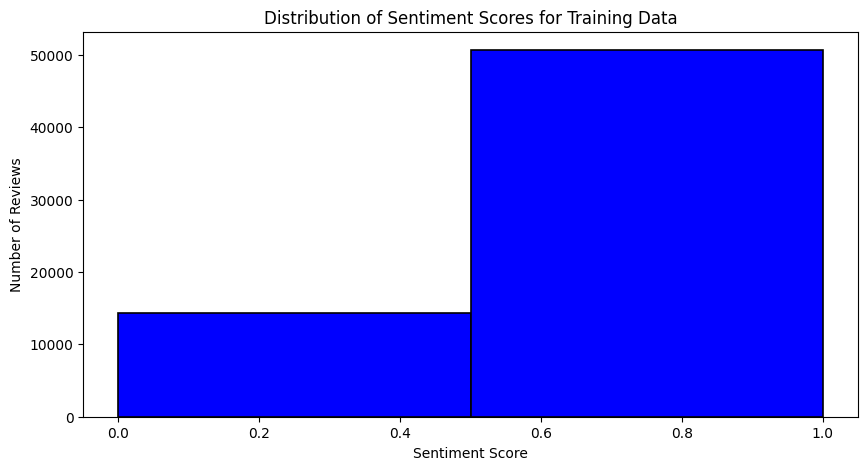

In [7]:
# Analyze distribution of sentiment scores training dataset
plt.figure(figsize=(10, 5))
plt.hist(y, bins=2, color='blue', edgecolor='black', linewidth=1.2)
plt.title('Distribution of Sentiment Scores for Training Data')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Reviews')
plt.show()

The imbalance after downsampling (done previously) is still there, but a little bit better. However, we will settle for this, since production data would likely have a similar distribution. In addition, we will test the model with data following this same distribution.

### Stopwords and Lemmatizing

Removing the stopwords means taking away the most common words in the english language, those that are not very significant when trying to analyze the sentiment in a sentence.

Lemmatizing means reducing each word to its "lemma", or the root of the word. For example, the lemma of "running" is "run". This is useful because it reduces the number of words that the model has to learn, and it also helps to group together words that have the same meaning.

In [8]:
# Remove stopwords
stop = nltk.corpus.stopwords.words('english')
lemmatized_text = df_downsampled['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Lemmatizing
lemmatizer = nltk.stem.WordNetLemmatizer()
lemmatized_text = lemmatized_text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

### Tokenize the text

Tokenizing the text is basically splitting the text into sequences words. Using the NLTK library to tokenize the text.

In [9]:
tokenized_text = [word_tokenize(i) for i in lemmatized_text]

### Word embeddings


Here, we load a previously trained model on this particular dataset. However, there are many alternatives for different models, as well as pretrained models that can be downloaded from the internet. For example, the [Stanford NLP group](https://nlp.stanford.edu/projects/glove/) has a set of pretrained models that can be used for sentiment analysis.

In [10]:
# This model was previously trained with this same dataset.
# The model was saved in a binary file with model.save()

#model = Word2Vec(tokenized_text, vector_size=128, window=5, min_count=1, workers=4)
#model.save("/content/drive/MyDrive/ColabProjects/model-500k-reviews.bin")


# Model trained on this dataset
# 500k version
model = KeyedVectors.load("/content/drive/MyDrive/ColabProjects/model-500k-reviews.bin")

# 50k version
#model = KeyedVectors.load("/content/drive/MyDrive/ColabProjects/model-50k-reviews.bin")


### Sequences
We now parse all reviews to sequences of words, but we use the Word2Vec model to do the word embeddings. This means that each token (word) is transformed into a dense vector. This is done so that the model can learn from these floats and find meaning in each review.

In [11]:
# Assigns each word in every sentence of every sequence a vector of the model.
# Depending if the model was loaded using load_word2vec_format, one would have to replace these:
# model.key_to_index <=> model.wv
# model.get_vector(token) <=> model.wv[token]

def create_sequences(tokenized_text, model):
    sequences = []
    for seq in tokenized_text:
        seq_vectors = []
        for token in seq:
            if token in model.wv:
                seq_vectors.append(model.wv[token])
            else:
                seq_vectors.append(np.zeros((model.vector_size,)))
        sequences.append(seq_vectors)

    return sequences


sequences = create_sequences(tokenized_text, model)

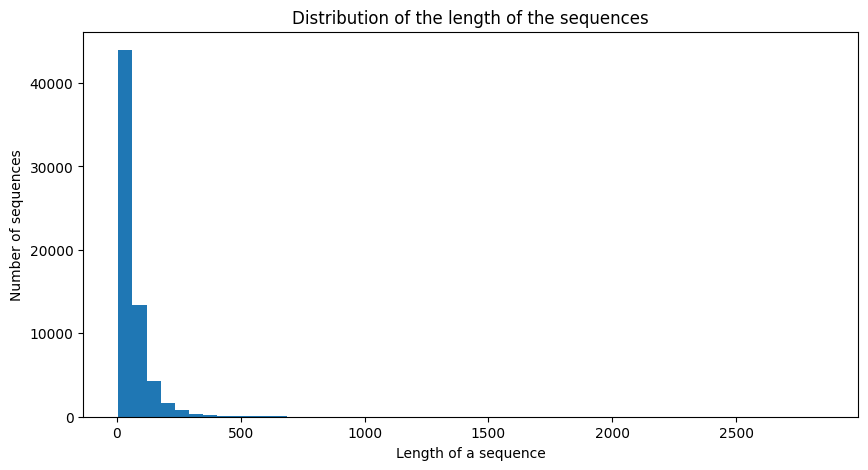

In [12]:
# Distribution of the length of the sequences
plt.figure(figsize=(10, 5))
plt.hist([len(s) for s in sequences], bins=50)
plt.xlabel('Length of a sequence')
plt.ylabel('Number of sequences')
plt.title('Distribution of the length of the sequences')
plt.show()


### Padding the sequences


This step is crucial, due to the fact that LSTMs cannot handle inhomogenous data, meaning that each sequence must be of the same length. The scikit learn pad_sequences function allows us to do this. We will pad the sequences with zeros, meaning that the sequences will be added the necessary zeros at the end. We will also need to define the maximum length of the sequences, which we will set to 100 in this case, by looking at the previous graph. This means that sequences with length less than 100 will be padded with zeros, and sequences with length greater than 10 will be truncated to 100.

In [13]:
MAXLEN = 100

sequences_padded = pad_sequences(sequences, maxlen=MAXLEN, padding='post', truncating='post', dtype='float32')

In [14]:
# How many sequences are we truncating?
print("Number of truncated sequences: ", len([x for x in sequences if len(x) > MAXLEN]))

Number of truncated sequences:  10412


# Data split

In [15]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(sequences_padded, y, test_size=0.2, random_state=27)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=27)

In [16]:
# Print shapes to check
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)



X_train shape:  (52000, 100, 128)
X_val shape:  (6500, 100, 128)
X_test shape:  (6500, 100, 128)
y_train shape:  (52000,)
y_val shape:  (6500,)
y_test shape:  (6500,)


# Model

Here, I am using LSTM layers, this choice was made after experimenting with GRUs (Gated Recurrent Units) and seeing that LSTMs performed better.   
For regularization, I am using dropout layers with 0.5 as the dropout rate.  
Since this is a binary classification problem, I am using a sigmoid activation function in the output layer, as well as a binary_crossentropy loss function.
The learning rate in the Adam optimizer is set to 0.0005 due to overfitting issues when using the default value of 0.001.

### Constants

In [17]:
EPOCHS = 18
BATCH_SIZE = 32
BATCHES_PER_EPOCH = 1625
DROPOUT_RATE = 0.4

### Class weights
Class weights help handle class imbalance. When certain classes have fewer examples, the model might favor the majority class. Class weights balance this by giving more importance to minority classes during training. This ensures the model learns from all classes and improves predictions, especially for rarer classes.
This weights are applied in the <b>modified loss function</b> below.

In [18]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)

class_weights = dict(enumerate(class_weights))

no_weights = {0: 1, 1: 1}

def weighted_binary_crossentropy(y_true, y_pred, weight_zero=class_weights[0], weight_one=class_weights[1]):
    #get the value without weights
    bin_crossentropy = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # apply the weights
    weights = y_true * weight_one + (1. - y_true) * weight_zero
    weighted_bin_crossentropy = weights * bin_crossentropy

    return weighted_bin_crossentropy

### Learning rate schedule
Learning rate schedules control the rate at which a model updates its parameters during training. Instead of a fixed learning rate, schedules adjust it over time. This helps improve convergence and performance. In this case, I used the PolynomialDecay schedule from keras.

In [19]:
lr_schedule = PolynomialDecay(initial_learning_rate=0.001,
                              decay_steps=EPOCHS * BATCHES_PER_EPOCH,
                              end_learning_rate=0.0003)

### Model architecture

In [20]:
rnn = Sequential()
#masking layer to mask the padded zeros
rnn.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))

rnn.add(LSTM(50, return_sequences=False, dropout=DROPOUT_RATE, kernel_regularizer=l2(0.01)))

rnn.add(Dense(1, activation='sigmoid'))

rnn.compile(loss=weighted_binary_crossentropy,
            optimizer=Adam(learning_rate=lr_schedule),
            metrics=['Precision', 'Recall', 'accuracy'])


In [21]:
H = rnn.fit(X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=(X_val, y_val))
            #callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True))

Epoch 1/18
1625/1625 [==============================] - 140s 83ms/step - loss: 0.5164 - precision: 0.8657 - recall: 0.9300 - accuracy: 0.8331 - val_loss: 0.3641 - val_precision: 0.9041 - val_recall: 0.9136 - val_accuracy: 0.8571
Epoch 2/18
1625/1625 [==============================] - 134s 82ms/step - loss: 0.3695 - precision: 0.8845 - recall: 0.9334 - accuracy: 0.8532 - val_loss: 0.3657 - val_precision: 0.9221 - val_recall: 0.8919 - val_accuracy: 0.8569
Epoch 3/18
1625/1625 [==============================] - 132s 82ms/step - loss: 0.3598 - precision: 0.8872 - recall: 0.9368 - accuracy: 0.8581 - val_loss: 0.3353 - val_precision: 0.8883 - val_recall: 0.9576 - val_accuracy: 0.8731
Epoch 4/18
1625/1625 [==============================] - 136s 83ms/step - loss: 0.3545 - precision: 0.8888 - recall: 0.9378 - accuracy: 0.8601 - val_loss: 0.3322 - val_precision: 0.9156 - val_recall: 0.9203 - val_accuracy: 0.8717
Epoch 5/18
1625/1625 [==============================] - 132s 81ms/step - loss: 0.348

## Predictions

In [22]:
predictions = rnn.predict(X_test)

# Round predictions
y_pred = np.zeros(len(predictions))
for i in range(len(predictions)):
    if predictions[i] > 0.65:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

# Print the precision and recall, among other metrics
print(classification_report(y_test, y_pred, digits=3))

204/204 [==============================] - 8s 29ms/step
              precision    recall  f1-score   support

         0.0      0.705     0.739     0.722      1419
         1.0      0.926     0.914     0.920      5081

    accuracy                          0.876      6500
   macro avg      0.816     0.826     0.821      6500
weighted avg      0.878     0.876     0.877      6500



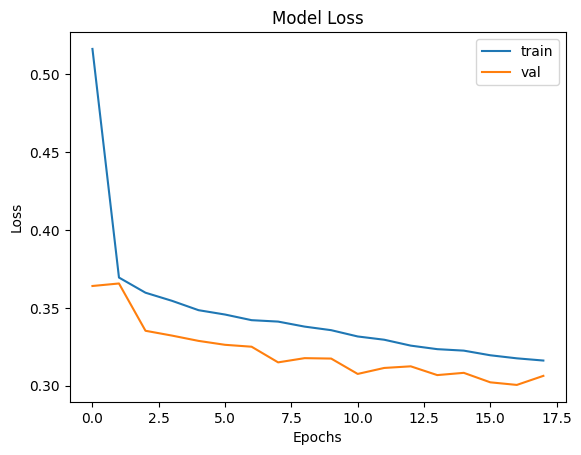

In [23]:
# plot the loss
plt.plot(H.history['loss'], label='train')
plt.plot(H.history['val_loss'], label='val')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



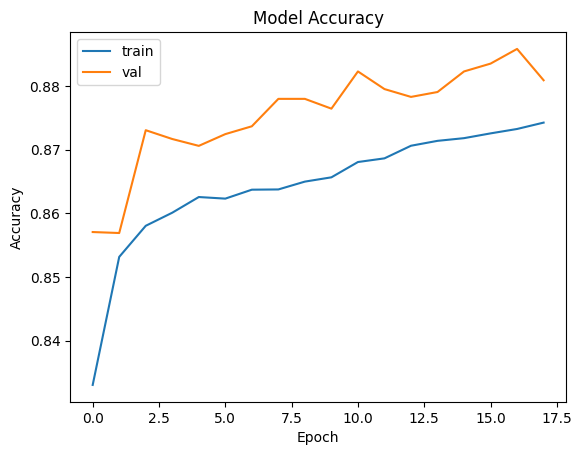

In [24]:
# Plot accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

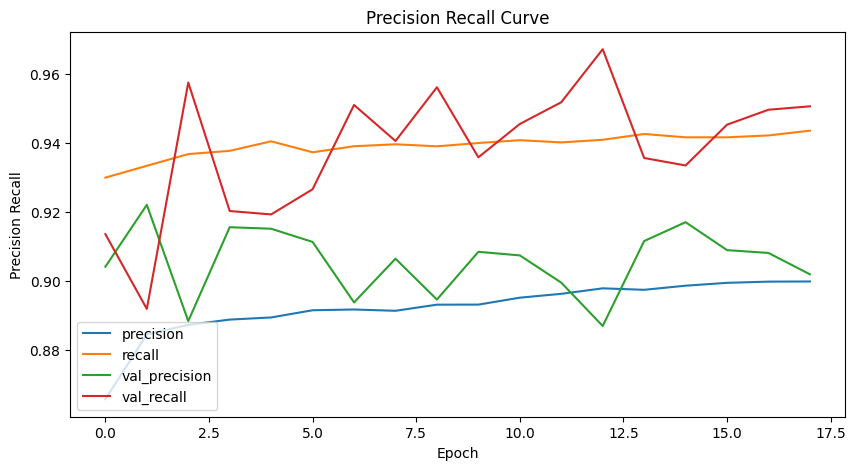

In [25]:
# Plot precision recall curve
plt.figure(figsize=(10, 5))
plt.plot(H.history['precision'], label='precision')
plt.plot(H.history['recall'], label='recall')
plt.plot(H.history['val_precision'], label='val_precision')
plt.plot(H.history['val_recall'], label='val_recall')
plt.title('Precision Recall Curve')
plt.xlabel('Epoch')
plt.ylabel('Precision Recall')
plt.legend(loc='lower left')
plt.show()

<a name="conclusions"></a>
# Conclusions
After training, we can see that the model achieved decent performance, though we will explore different structures, datasets and configurations. This is why, in separate notebooks, I have tried to solve the same problem using different approaches. Here are the ones I have tried. Note that these notebooks won't have the explanations on Data Preprocessing as they would be repetitive and hard to read.


- [CNN with Word2Vec](https://colab.research.google.com/drive/1xTQ2L_PnlBlrV6YlydVkqTxhIfzk5t0V?usp=sharing)
  - In this notebook, I have used a Convolutional Neural Network (CNN) instead of a Recurrent Neural Network. Though CNNs are often associated with image processing, they can also be used for text classification tasks. They work well for capturing local patterns in sequences.
  - This model is still in progress, but so far it has not surpassed the RNN in performance

- [CNN with Embeddings Layer](https://colab.research.google.com/drive/1oWPNlz0XKTXGRasXaoBU8q9yw9Uq1rEq?usp=sharing)
  - This model is pretty much the same as the previous one, but instead of vectorizing each word previous to training the model, it does so with an Embedding layer, which is trained alongside the model. This model has shown to be much slower in training and performed similarly as the model with the pretrained embeddings.

- [RNN with Imbalanced Test Dataset](https://colab.research.google.com/drive/1rFsPGL9Yz23mB9cipIQBAUT7VBTqPNyF?usp=sharing)
  - This model is pretty much the same as this one, with the difference that it uses the balanced dataset for training the model (the one which has a 60-40 split in positive-negative reviews), but it uses an "imbalanced" dataset for training, the one which doesn't have the positive reviews undersampled to even out the proportions
  - This model has performed quite well, almost matching the performance of this RNN model.

After seeing the results in each implementation, we can see that the one with the highest performance was this one, the Recurrent Neural Network with the "imbalanced" training dataset.